# Burst Detection Using burst.py
This notebook shows how to use detect EEG bursts using the `neurodsp.burst` module.

In [1]:
import numpy as np
import neurodsp

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

### Generate fake bursting data
Here we'll simulate bursting activity in the alpha range on top of some simple sine waves. Afterwards, we'll use this data to show some of the pros and cons of individual burst detection algorithms, to give you a good idea on which one(s) you'd like to use in your own work.

In [2]:
# Generate quasi-periodic data with an alpha burst
np.random.seed(0)
t = np.arange(0,2,.001)
x = 30*np.random.randn(len(t)) + 50*np.sin(t*2*np.pi*1.3) + 30*np.sin(t*2*np.pi*18-.3) # background activity
x[500:1000] += 80*np.sin(t[500:1000]*2*np.pi*10) # add in alpha burst
Fs = 1000

# Define the frequency band of interest
alpha = (8, 12)

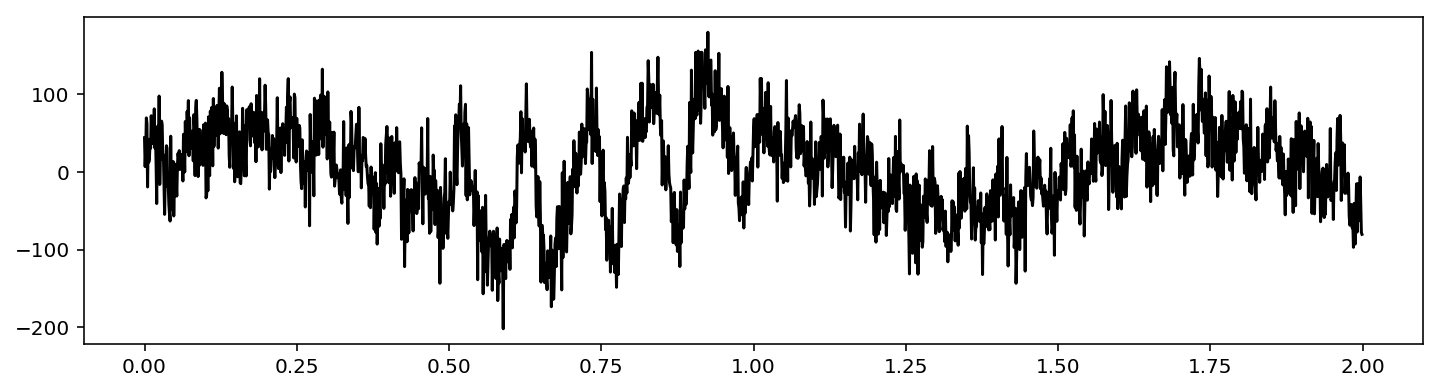

In [3]:
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');

We can see that there is a clear range of alpha band activity from 500 to 1000 ms and fairly uniform background activity elsewhere.  

### Deviation Algorithm
**Background:**  
This algorithm is one of the most basic found in neurodsp.burst. It first computes the amplitude at each point in time for a given frequency range. Then, it determines periods of bursting by using the average amplitude of the whole time series. The output depends on the 'thresh' parameter, which in the form (low, high). Any time point at which the amplitude is higher than $high * average\_amplitude$ will be considered bursting. Then the algorithm goes back to each period of bursting activity and includes anything above $low * average\_amplitude$ which is just leading up to, or just following, a period of bursting activity.  
  
**Other Parameters:**
* The $average\_amplitude$ can be set to either the mean or median by modifying the 'deviation_type' keyword argument. 
* Power can be used instead of amplitude by modifying the 'magnitude_type' keyword argument.
  
**Uses:**  
The Deviation algorithm is a simple method for burst detection, and should be used when the direct interpretation of the output is beneficial. As will be shown in future iterations of this tutorial, other algorithms can be more robust than Deviation in several cases.  

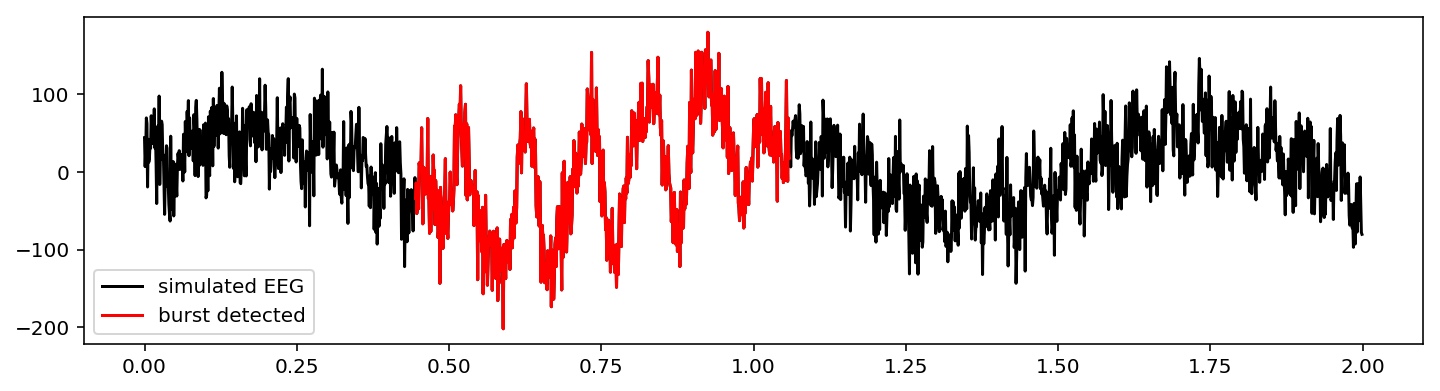

In [4]:
# Detect bursts using 'deviation' algorithm
bursting = neurodsp.detect_bursts(x, Fs, alpha, algorithm='deviation', dual_thresh=(3, 3))

# Get indices for bursting using 'deviation' algorithm
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');
plt.plot(t[bursting_i], x[bursting_i], 'r', label='burst detected')
plt.legend(loc='best');

The graph above shows the bursting activity in red. The Deviation algorithm was used with thresh=(3, 3), so any time point with more than 3 times the median magnitude in the alpha range (8-12 Hz) was marked as bursting activity.  

This next graph might help understand the algorithm a bit better, or to help with troubleshooting when the algorithms don't act the way we expect. We'll take advantage of the return_amplitude option in detect_bursts().

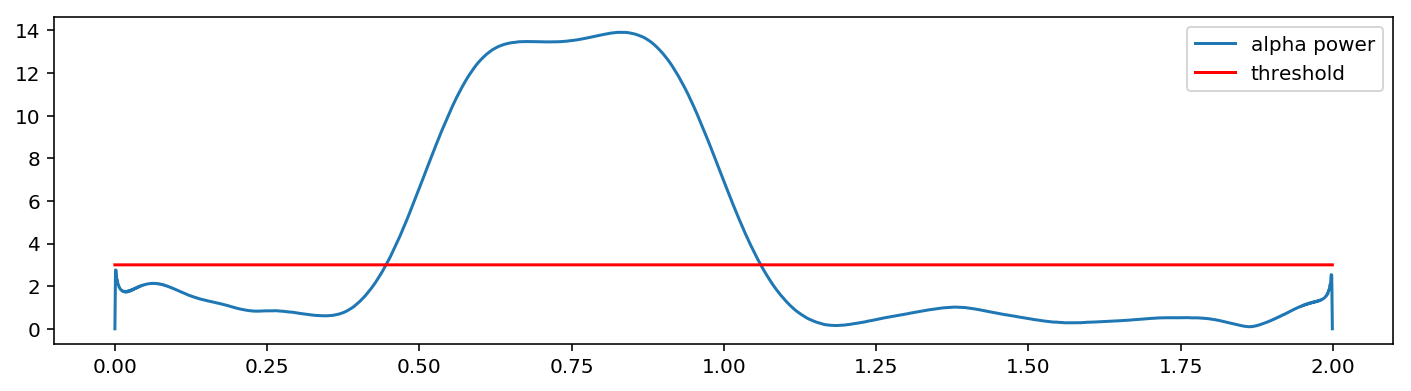

In [5]:
# Get amplitudes
bursting, power = neurodsp.detect_bursts(x, Fs, alpha, algorithm='deviation', return_amplitude=True, dual_thresh=(3, 3))

# Plot alpha power
plt.figure(figsize=(12,3));
plt.plot(t, power, label='alpha power');
plt.plot(t, 3*np.ones(len(t)), 'r', label='threshold')
plt.legend(loc='best');

We can see that the a time point is considered to be in a burst if the power within the alpha range is greater than the threshold at that time.  

### Fixed Threshold Algorithm
**Background:**  
The Fixed Threshold algorithm is very similar to the Deviation algorithm, but uses absolute values in the 'thresh' parameter. Instead of using a factor times the average amplitude, it just uses the amplitude at the given time point. We can see below that similar results are found by using thresh=(10, 20), which are given in the same units as the magnitude of our time series (unless power is used by modifying the 'magnitude_type' parameter). 
  
**Uses:**  
Fixed Threshold could be used anytime Deviation could be used. When a hands off approach is wanted, Deviation should be used; but, if you are already familiar with your data's power spectra, you might have certain magnitude (or power) values in mind. In this case, you might prefer the direct use of magnitude values. It also comes in handy when the average magnitude is not a good metric to use for your data, but you'd still like a directly interpretable result from the burst detection algorithm.  

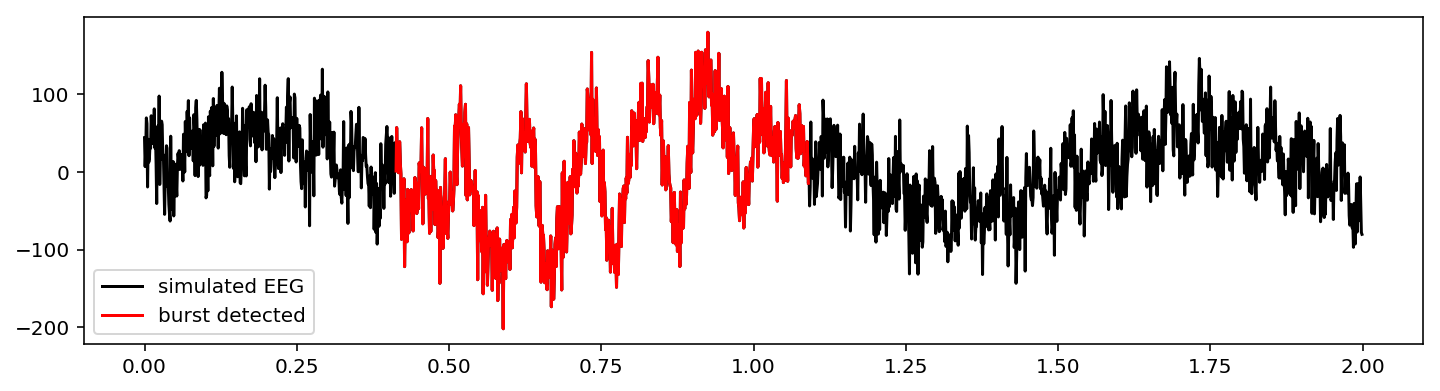

In [6]:
# Detect bursts using 'fixed_thresh'
bursting = neurodsp.detect_bursts(x, Fs, alpha, algorithm='fixed_thresh', dual_thresh=(10, 20))

# Get indices for bursting
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');
plt.plot(t[bursting_i], x[bursting_i], 'r', label='burst detected')
plt.legend(loc='best');

### Better OSCillation detection (BOSC) method (Whitten et al., 2011, NeuroImage
This burst detector fits the background spectra linear noise process in order to automatically derive a power threshold for detecting bursts.

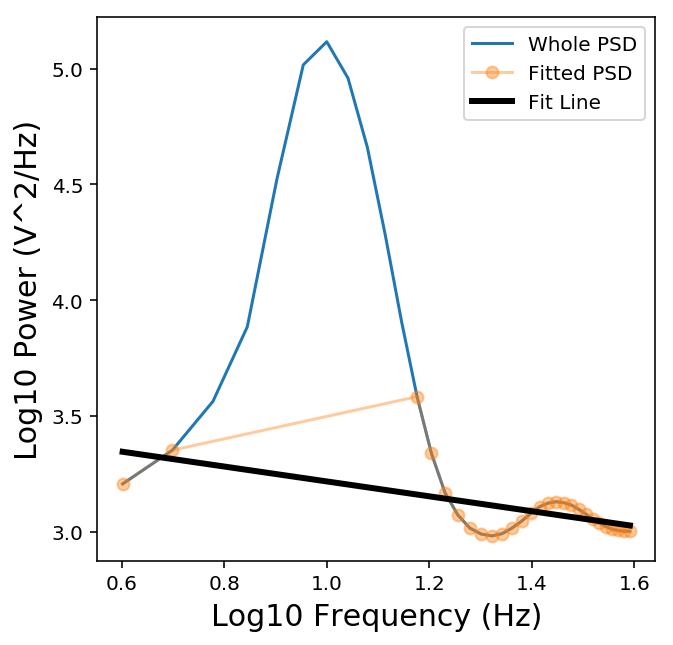

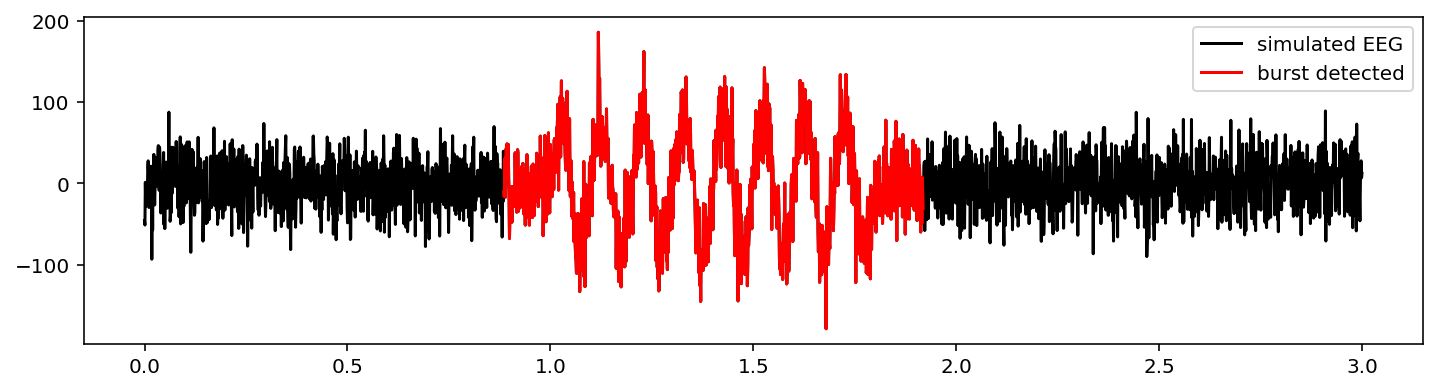

In [7]:
# Simulate new data that is an oscillation over a noise process with a linear spectrum
f_oi = 10 # 10Hz oscillation of interest
t_x2 = np.arange(0, 3, .001)
x2 = 30*np.random.randn(len(t_x2))
x2[1000:1800] += 80*np.sin(t_x2[1000:1800]*2*np.pi*f_oi) # add in alpha burst

# Detect bursts using 'bosc'
f_range_slope = (4,40)
f_slope_excl = (6,14)
bursting = neurodsp.detect_bursts_bosc(x2, Fs, f_oi, f_range_slope, f_slope_excl, plot_slope_fit=True)

# Get indices for bursting
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3))
plt.plot(t_x2, x2, 'k', label='simulated EEG')
plt.plot(t_x2[bursting_i], x2[bursting_i], 'r', label='burst detected')
plt.legend(loc='best')

### Real Data
Here we will test `detect_bursts` on actual neural data.

In [8]:
from neurodsp.tests import _load_example_data

x = _load_example_data(data_idx=1)

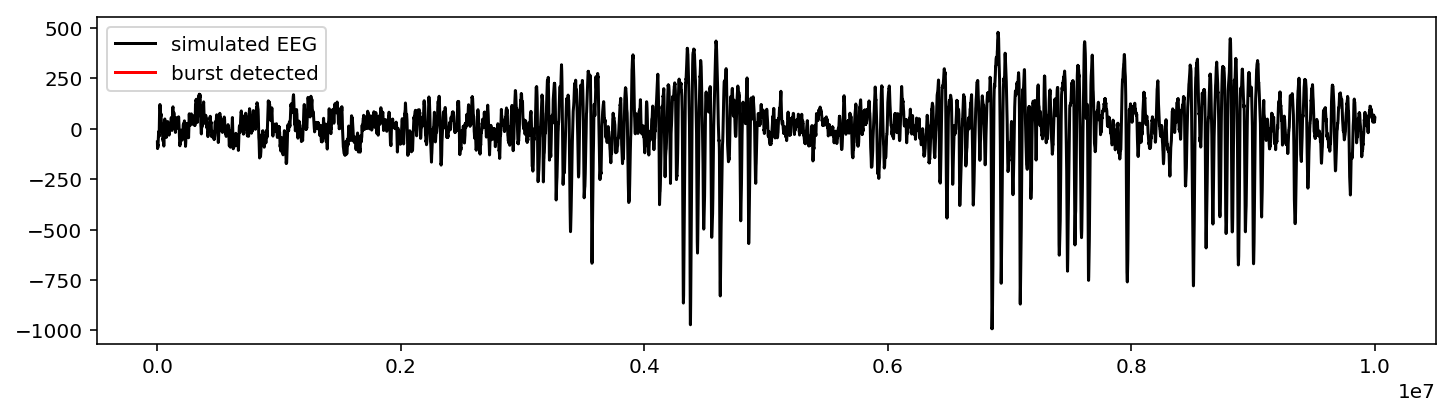

In [9]:
# Same code as earlier

t = np.arange(len(x)*Fs, step=Fs)

# Detect bursts using 'deviation' algorithm
bursting = neurodsp.detect_bursts(x, Fs, alpha, algorithm='deviation', dual_thresh=(3, 3))

# Get indices for bursting using 'deviation' algorithm
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');
plt.plot(t[bursting_i], x[bursting_i], 'r', label='burst detected')
plt.legend(loc='best');

In [10]:
np.sum(bursting)

0.0

No bursts were detected! There could be a number of reasons for this. One of the easy things to do is to adjust the parameters for burst detection. Let's try making the thresholds lower.

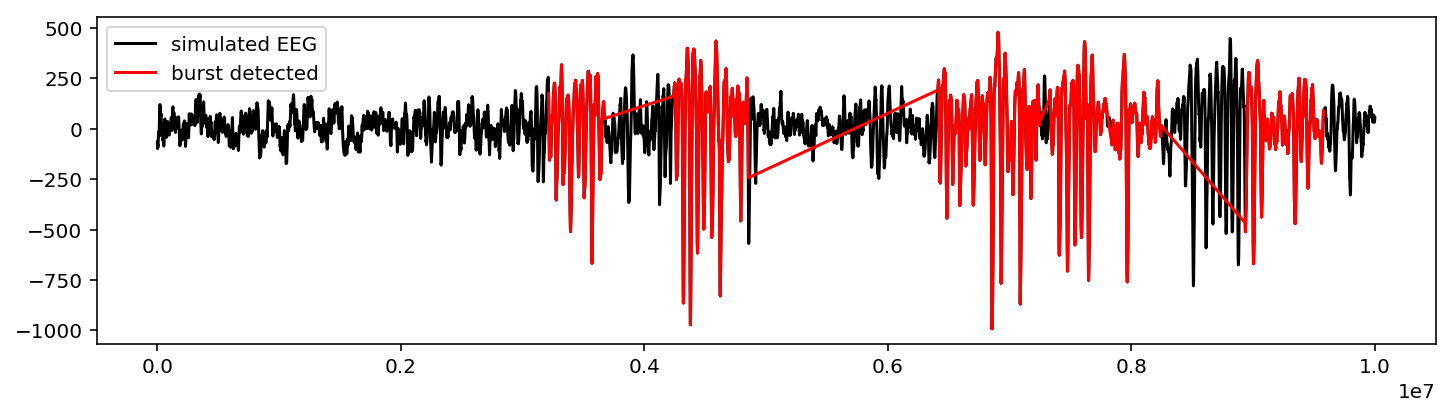

In [11]:
# Detect bursts using 'deviation' algorithm
bursting = neurodsp.detect_bursts(x, Fs, alpha, algorithm='deviation', dual_thresh=(0.9, 2))

# Get indices for bursting using 'deviation' algorithm
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');
plt.plot(t[bursting_i], x[bursting_i], 'r', label='burst detected')
plt.legend(loc='best');

Better, but not very good. There's another serious issue: we're looking for alpha bursts, but the bursts in this data are *beta* bursts.  

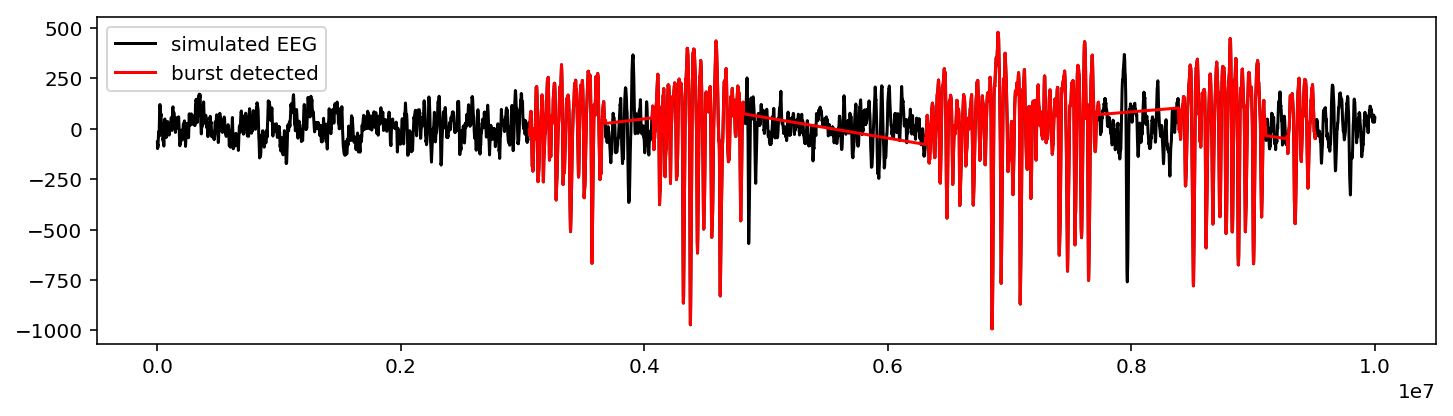

In [12]:
beta = (13, 30)

bursting = neurodsp.detect_bursts(x, Fs, beta, algorithm='deviation', dual_thresh=(0.9, 2.0))

# Get indices for bursting using 'deviation' algorithm
bursting_i = np.where(bursting)

# Plot original signal and burst activity
plt.figure(figsize=(12,3));
plt.plot(t, x, 'k', label='simulated EEG');
plt.plot(t[bursting_i], x[bursting_i], 'r', label='burst detected')
plt.legend(loc='best');

Much better! This just goes to show that burst detection is an art that requires some knowledge of the data you're working with.